In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import idx2numpy
data = idx2numpy.convert_from_file('D:/data/train-images.idx3-ubyte')
data_labels = idx2numpy.convert_from_file('D:/data/train-labels.idx1-ubyte')
df = data
df_labels = data_labels

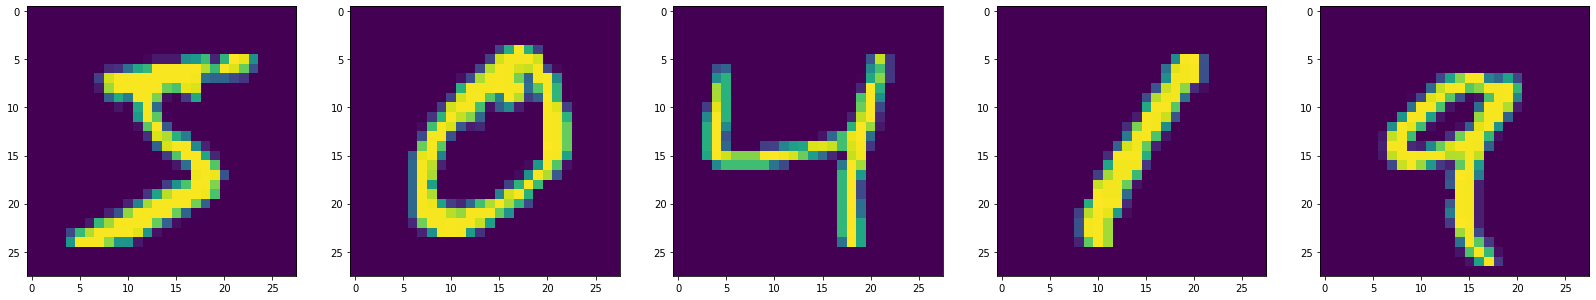

In [3]:
fig, axs = plt.subplots(1, 5, figsize=(28, 28))
for i in range(0, 5):
    axs[i].imshow(data[i, :])

In [4]:
df = df.reshape((60000, 28 * 28))

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

In [7]:
y_pred = kn.predict(X_test)

In [8]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9715

[3] [9] [3] [5] [2] 

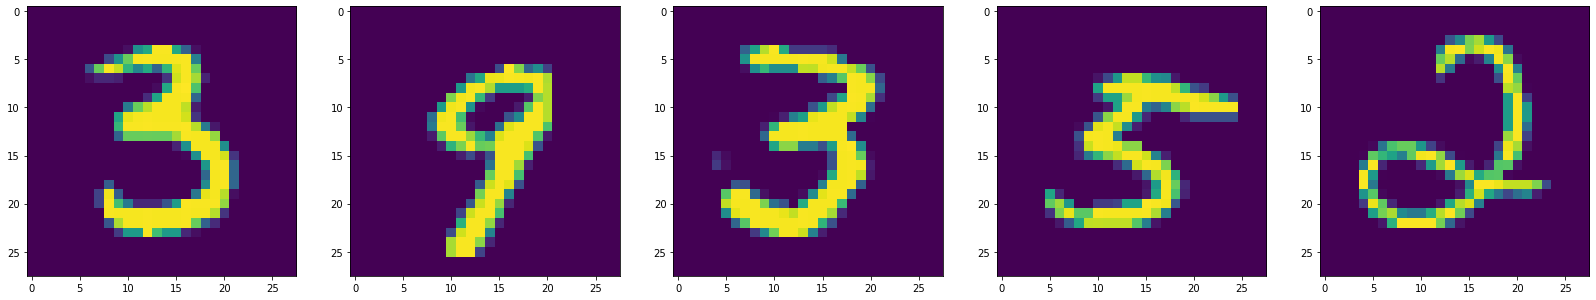

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(28, 28)) # вывод случайной чифры с предсказанием модели
for i in range(5):
    ran = np.random.randint(len(y_test))
    axs[i].imshow(X_test[ran, :].reshape((28, 28)))
    print(kn.predict(X_test[ran:ran+1, :]), end=" ")

In [10]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
np.fill_diagonal(conf_mat, 0)

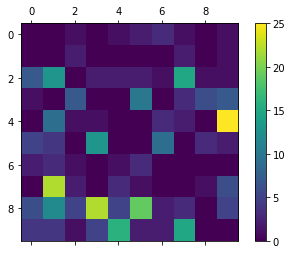

In [11]:
fig, axs = plt.subplots()
mat_show = axs.matshow(conf_mat)
fig.colorbar(mat_show)
plt.show()

In [12]:
def min_max_normalization(X):
    min_arr, max_arr = np.min(X), np.max(X)
    return ((X - min_arr) / (max_arr - min_arr)).astype("float32")
X_train = min_max_normalization(X_train)
X_test = min_max_normalization(X_test)

In [13]:
#реализация алгоритма k-ближайщих соседей

def all_distances_point(x_train, point): # расстояние между каждой точки до нужной
    distances = np.sqrt(np.sum(np.power((x_train - point), 2), axis=1))
    return distances

def nearest_neighbor_method(x_train, y_train, x_test, k = 5): # непосредственно метод ближайщих соседей
    y_pred = np.array([])
    for i in x_test:
        distance = all_distances_point(x_train, i)
        dist_argsort = np.argsort(distance)
        unique, counts = np.unique(y_train[dist_argsort[:k]], return_counts=True) # подсчитываем количество уникальных соседей с выбором k ближайших
        count_neighbours = np.column_stack((unique, counts.T))
        index = np.random.choice(np.where(count_neighbours[:, 1] == np.max(count_neighbours[:, 1]))[0]) # выбираем случайного соседа из наиболее повторяющийся
        pred_class = count_neighbours[index, 0]
        y_pred = np.append(y_pred, pred_class)
    return y_pred

In [14]:
y_pred = nearest_neighbor_method(X_train, y_train, X_test[:1000, :]) # я здесь взял первые 1000 записей потому что метод очень долго делает вычисления

In [15]:
def accuracy(y_test, y_pred): # оценка точность алгоритма
    matrix = y_test == y_pred
    return np.float64(np.sum(matrix) / len(matrix))

In [16]:
print(accuracy(y_test[:1000], y_pred))

0.972


In [18]:
import tensorflow as tf 

In [19]:
df = tf.keras.utils.normalize(data)
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

In [20]:
# реализация LeNet-5

# задание входных данных
X = tf.keras.Input(shape=(28, 28))
X_extended = tf.reshape(X, [-1, 28, 28, 1]) # я изменил здесь размер, потому что conv2d принимает на вход только 4 мерный тенсор
# 1 значение - это количество взодных данных, 2 и 3 - размер картинки, а 4 - количество цветовых каналов

c1 = tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding="same", activation=tf.nn.tanh)(X_extended) # свёрточный слой
#c1 = tf.compat.v1.layers.conv2d(X_extended, filters=6, kernel_size=5, padding="same", activation=tf.nn.tanh)
s2 = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(c1) # объединение по среднему
c3 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation=tf.nn.tanh)(s2)
s4 = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(c3)
c5 = tf.keras.layers.Conv2D(filters=120, kernel_size=5)(s4)
flat = tf.keras.layers.Flatten()(c5) # выравнивает слой в одномерный массив
f6 = tf.keras.layers.Dense(84, activation=tf.nn.tanh)(flat) # послосвязный слой
out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(f6) # выходной слой
model = tf.keras.Model(inputs=X, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                 

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=100, epochs=3) # тренировка модели

Epoch 1/3
480/480 [==============================] - 8s 15ms/step - loss: 0.4090 - accuracy: 0.8767
Epoch 2/3
480/480 [==============================] - 7s 15ms/step - loss: 0.2013 - accuracy: 0.9393
Epoch 3/3
480/480 [==============================] - 7s 15ms/step - loss: 0.1487 - accuracy: 0.9550


In [22]:
model.evaluate(X_test, y_test) # вывод функции потерь и точность алгоритма

375/375 [==============================] - 2s 4ms/step - loss: 0.1263 - accuracy: 0.9597


[0.12629930675029755, 0.9597499966621399]

In [23]:
df = data.reshape((60000, 28 * 28))
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

In [24]:
def min_max_normalization(X):
    min_arr, max_arr = np.min(X), np.max(X)
    return ((X - min_arr) / (max_arr - min_arr)).astype("float32")
X_train = min_max_normalization(X_train)
X_test = min_max_normalization(X_test)

In [25]:
def onehot(y, outputs):
    y_onehot = []
    for i in y:
        one_hot = np.zeros((1, outputs))
        one_hot[0, i] = 1
        y_onehot.append(one_hot)
    return y_onehot

In [26]:
# реализация многослойного перцептрона с обратным распространением ошибки без использования tensorflow

n_inputs = 784
n_outputs = 10
n_hidden1 = 300
n_hidden2 = 100

#инициализация весов для нейрона
def scale_initiation(height, width):
    return np.random.normal(size=(height, width))

# сигмоида
def sigma(x): # функция активации
    return 1 / (1 + np.exp(-x))

# подсчет выходного значения нейронов
def neuron_output(weights, inputs):
    return sigma(np.dot(inputs, weights))

# определение выроятность принадлежность к каждому классу
def softmax(output):
    return np.exp(output) / np.sum(np.exp(output))

# создание полносвязного слоя
def perceptron(neural_network, n_inputs, n_outputs):
    weights = scale_initiation(n_inputs, n_outputs)
    bias = np.random.normal(size=(1, n_outputs))
    neural_network.append({"weights" : weights, "bias" : bias})

def output_values(neural_network, input_values, layer, activation = sigma):    
    neural_network[layer]["output"] = activation(np.dot(input_values, neural_network[layer]["weights"]) + neural_network[layer]["bias"])
    return neural_network[layer]["output"]
# вычисление ошибки для каждого выходного нейрона в скрытом слое
def error_calculation(x):
    return x * (1.0 - x)

# перекрёстная энтропия для множественной классификации
def entropy(y_pred, y):
    return -np.sum(np.log(y_pred) * y)

# вычисление ошибки для каждого выходного нейрона в скрытом слое
def error_calculation(x):
    return x * (1.0 - x)

# вычисление ошибки для каждого нейрона
def delta_calculation(neural_network, y):
    for i in reversed(range(len(neural_network))):
        layer = neural_network[i]
        if i == len(neural_network) - 1:
            errors = np.array(y).reshape((1, 10)) - layer["output"]
            layer["delta"] = np.multiply(errors, error_calculation(layer["output"]))
        else:
            errors = np.dot(neural_network[i + 1]["delta"], neural_network[i + 1]["weights"].T)
            layer["delta"] = errors * error_calculation(layer["output"])
            layer["delta_bias"] = np.sum(layer["delta"])

# обновление весов
def weight_update(neural_network, learning_rate=0.1):
    for i in range(len(neural_network)):
        layer = neural_network[i]
        if i > 0:
            layer["weights"] += learning_rate * np.dot(neural_network[i - 1]["output"].T, layer["delta"])
            if i != len(neural_network) - 1:
                layer["bias"] += learning_rate * layer["delta_bias"]
                
def predict(neural_network, X_test):
    y_pred = []
    for i in X_test:
        output_values(neural_network, i, 0)
        output_values(neural_network, neural_network[0]["output"], 1)
        output_values(neural_network, neural_network[1]["output"], 2, softmax)
        y_pred.append(np.argmax(neural_network[2]["output"]))
    return y_pred

In [27]:
def fit(X_train, y_train, epochs=2): # тренировка модели
    neural_network = []
    loss = 10**10
    neural_network_best_param = 0
    
    perceptron(neural_network, n_inputs, n_hidden1) # создание 1 скрытого слоя
    perceptron(neural_network, n_hidden1, n_hidden2) # создание 2 скрытого слоя
    perceptron(neural_network, n_hidden2, n_outputs) # создание выходного слоя
    
    for j in range(epochs):
        for i in range(len(X_train)):
            output_values(neural_network, X_train[i, :], 0)
            output_values(neural_network, neural_network[0]["output"], 1)
            y_pred = output_values(neural_network, neural_network[1]["output"], 2, softmax) # предсказание значения
            y = onehot(y_train[i:i+1], 10)
            ent = entropy(y_pred, y)
            if loss > ent:
                loss = ent 
                neural_network_best_param = neural_network.copy() # сохранение лучших весов сети
            delta_calculation(neural_network, y) # вычисление ошибки для каждого веса
            weight_update(neural_network) # обновление веса
    return neural_network_best_param

In [33]:
neural_network  = fit(X_train, y_train)

In [34]:
y_pred = predict(neural_network, X_train)
accuracy(y_train, y_pred)

0.7938541666666666

In [35]:
y_pred = predict(neural_network, X_test) 
accuracy(y_test, y_pred) # оценка точность алгоритма

0.7935

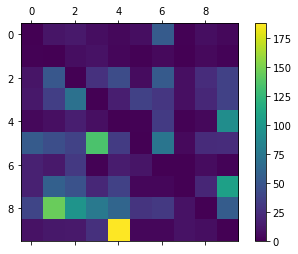

In [36]:
conf_mat = confusion_matrix(y_test, y_pred)
np.fill_diagonal(conf_mat, 0)
fig, axs = plt.subplots()
mat_show = axs.matshow(conf_mat)
fig.colorbar(mat_show)
plt.show()

[2] [5] [1] [6] [3] 

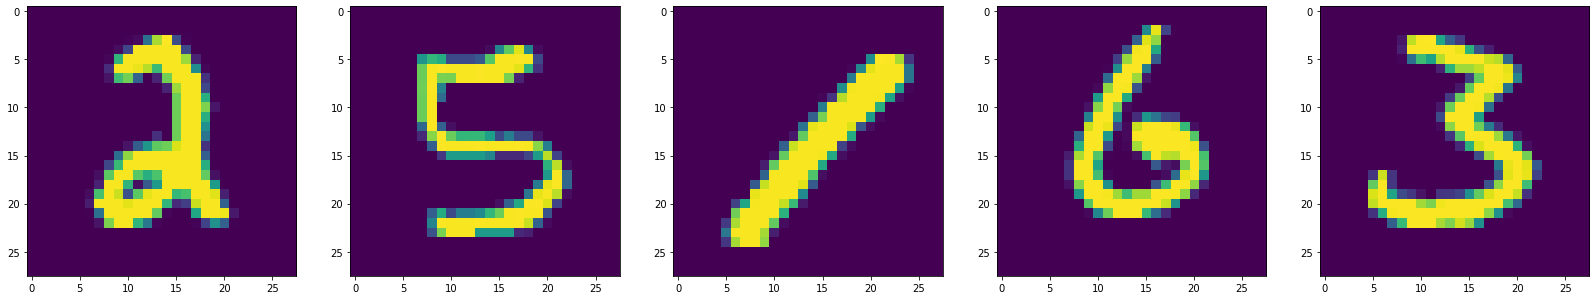

In [37]:
fig, axs = plt.subplots(1, 5, figsize=(28, 28)) # вывод случайной чифры с предсказанием модели
for i in range(5):
    ran = np.random.randint(len(y_test))
    axs[i].imshow(X_test[ran, :].reshape((28, 28)))
    print(predict(neural_network, X_test[ran:ran+1, :]), end=" ")